# Getting started with CUDA (Deprecated -- please use cuda-mode/lectures repo instead of this one)

## Setup

In [1]:
import torch, os, math
import torchvision as tv
import torchvision.transforms.functional as tvf
from torchvision import io
import matplotlib.pyplot as plt
from torch.utils.cpp_extension import load_inline

In [2]:
img = io.read_image('puppy.jpg')
print(img.shape)
img[:2,:3,:4]

torch.Size([3, 1330, 1920])


tensor([[[225, 225, 225, 225],
         [225, 225, 225, 225],
         [225, 225, 225, 225]],

        [[228, 228, 228, 228],
         [228, 228, 228, 228],
         [228, 228, 228, 228]]], dtype=torch.uint8)

In [3]:
def show_img(x, figsize=(4,3), **kwargs):
    plt.figure(figsize=figsize)
    plt.axis('off')
    if len(x.shape)==3: x = x.permute(1,2,0)  # CHW -> HWC
    plt.imshow(x.cpu(), **kwargs)

In [4]:
img2 = tvf.resize(img, 150, antialias=True)
ch,h,w = img2.shape
ch,h,w,h*w

(3, 150, 216, 32400)

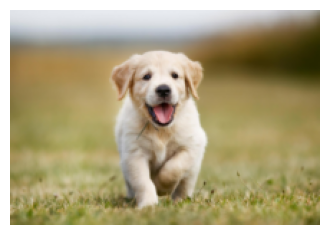

In [5]:
show_img(img2)

## RGB -> Grey

### Basic Python

In [6]:
def rgb2grey_py(x):
    c,h,w = x.shape
    n = h*w
    x = x.flatten()
    res = torch.empty(n, dtype=x.dtype, device=x.device)
    for i in range(n): res[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n]
    return res.view(h,w)

In [7]:
%%time
img_g = rgb2grey_py(img2)

CPU times: total: 1.83 s
Wall time: 1.95 s


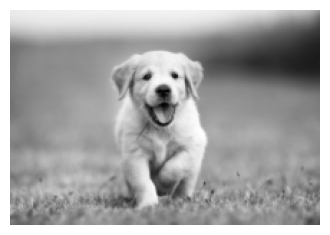

In [8]:
show_img(img_g, cmap='gray')

### Python Kernel

In [9]:
def run_kernel(f, times, *args):
    for i in range(times): f(i, *args)

NB: A kernel can not return anything. It can only change contents of things passed to it.

In [10]:
def rgb2grey_k(i, x, out, n):
    out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n]

In [11]:
def rgb2grey_pyk(x):
    c,h,w = x.shape
    n = h*w
    x = x.flatten()
    res = torch.empty(n, dtype=x.dtype, device=x.device)
    run_kernel(rgb2grey_k, h*w, x, res, n)
    return res.view(h,w)

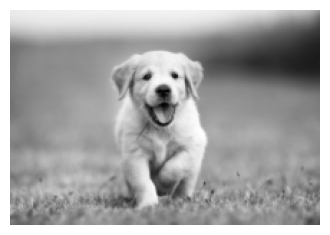

In [12]:
img_g = rgb2grey_pyk(img2)
show_img(img_g, cmap='gray')

### Python Block Kernel

In [13]:
def blk_kernel(f, blocks, threads, *args):
    for i in range(blocks):
        for j in range(threads): f(i, j, threads, *args)

In [14]:
def rgb2grey_bk(blockidx, threadidx, blockdim, x, out, n):
    i = blockidx*blockdim + threadidx
    if i<n: out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n]

In [15]:
def rgb2grey_pybk(x):
    c,h,w = x.shape
    n = h*w
    x = x.flatten()
    res = torch.empty(n, dtype=x.dtype, device=x.device)
    threads = 256
    blocks = int(math.ceil(h*w/threads))
    blk_kernel(rgb2grey_bk, blocks, threads, x, res, n)
    return res.view(h,w)

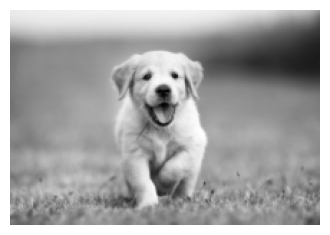

In [16]:
img_g = rgb2grey_pybk(img2)
show_img(img_g, cmap='gray')

### CUDA Setup

In [3]:
os.environ['CUDA_LAUNCH_BLOCKING']='1'

In [4]:
def load_cuda(cuda_src, cpp_src, funcs, opt=False, verbose=False):
    return load_inline(cuda_sources=[cuda_src], cpp_sources=[cpp_src], functions=funcs,
                       extra_cuda_cflags=["-O2"] if opt else [], verbose=verbose, name="inline_ext")

In [22]:
cuda_begin = r'''
#include <torch/extension.h>
#include <stdio.h>
#include <c10/cuda/CUDAException.h>

#define CHECK_CUDA(x) TORCH_CHECK(x.device().is_cuda(), #x " must be a CUDA tensor")
#define CHECK_CONTIGUOUS(x) TORCH_CHECK(x.is_contiguous(), #x " must be contiguous")
#define CHECK_INPUT(x) CHECK_CUDA(x); CHECK_CONTIGUOUS(x)

inline unsigned int cdiv(unsigned int a, unsigned int b) { return (a + b - 1) / b;}
'''

### CUDA kernel

- 2^31 max blocks for dim 0, 2^16 max for dims 1 & 2
- 1024 max threads per block (use a multiple of 32)

In [23]:
cuda_src = cuda_begin + r'''
__global__ void rgb_to_grayscale_kernel(unsigned char* x, unsigned char* out, int n) {
    int i = blockIdx.x*blockDim.x + threadIdx.x;
    if (i<n) out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n];
}

torch::Tensor rgb_to_grayscale(torch::Tensor input) {
    CHECK_INPUT(input);
    int h = input.size(1);
    int w = input.size(2);
    printf("h*w: %d*%d\n", h, w);
    auto output = torch::empty({h,w}, input.options());
    int threads = 256;
    rgb_to_grayscale_kernel<<<cdiv(w*h,threads), threads>>>(
        input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), w*h);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}'''

In [24]:
cpp_src = "torch::Tensor rgb_to_grayscale(torch::Tensor input);"

In [25]:
module = load_cuda(cuda_src, cpp_src, ['rgb_to_grayscale'], verbose=True)

Using /home/jhoward/.cache/torch_extensions/py311_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/jhoward/.cache/torch_extensions/py311_cu121/inline_ext/build.ninja...
Building extension module inline_ext...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=inline_ext -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /home/jhoward/miniconda3/lib/python3.11/site-packages/torch/include -isystem /home/jhoward/miniconda3/lib/python3.11/site-packages/torch/include/torch/csrc/api/include -isystem /home/jhoward/miniconda3/lib/python3.11/site-packages/torch/include/TH -isystem /home/jhoward/miniconda3/lib/python3.11/site-packages/torch/include/THC -isystem /home/jhoward/miniconda3/include -isystem /home/jhoward/miniconda3/include/python3.11 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -c /home/jhoward/.cache/torch_extensions/py311_cu121/inline_ext/main.cpp -o main.o 
[2/3] /home/jhoward/miniconda3/bin/nvcc  -DTORCH_EXTENSION_NAME=inline_ext -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /home/jhoward/minicon

Loading extension module inline_ext...


In [27]:
[o for o in dir(module) if o[0]!='_']

['rgb_to_grayscale']

In [29]:
imgc = img.contiguous().cuda()

In [30]:
%%time
res = module.rgb_to_grayscale(imgc).cpu()
h,w = res.shape
h,w,h*w

CPU times: user 1.01 ms, sys: 154 µs, total: 1.17 ms
Wall time: 683 µs
h*w: 1330*1920


(1330, 1920, 2553600)

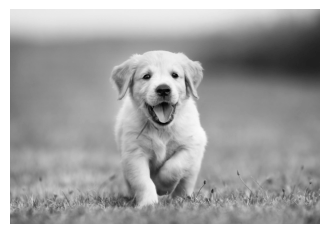

In [31]:
show_img(res, cmap='gray')

## Matmul

### Get data

In [75]:
import gzip,pickle
from urllib.request import urlretrieve
from pathlib import Path
from torch import tensor

In [71]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'
if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)

In [76]:
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train,y_train,x_valid,y_valid = map(tensor, (x_train,y_train,x_valid,y_valid))
x_train.shape,x_train.type()

(torch.Size([50000, 784]), 'torch.FloatTensor')

In [256]:
imgs = x_train.reshape((-1,28,28))
imgs.shape

torch.Size([50000, 28, 28])

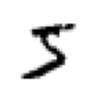

In [257]:
show_img(imgs[0], cmap='gray_r', figsize=(1,1))

In [258]:
torch.manual_seed(1)
weights = torch.randn(784,10)
weights

tensor([[-1.53, -0.75, -0.65,  ..., -1.61, -0.71,  0.30],
        [-0.78, -0.25, -0.22,  ..., -1.16,  0.70,  0.20],
        [ 0.87,  0.24, -0.66,  ..., -1.45,  0.06, -0.62],
        ...,
        [ 0.51,  0.47, -0.26,  ...,  0.65,  0.43, -1.29],
        [ 0.52,  1.03,  0.81,  ..., -0.10,  2.26, -0.28],
        [-1.49,  0.39, -0.55,  ..., -0.19, -0.51,  0.54]])

### Python matmul

In [259]:
m1 = x_valid[:5]
m2 = weights
m1.shape,m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [260]:
ar,ac = m1.shape # n_rows * n_cols
br,bc = m2.shape
(ar,ac),(br,bc)

((5, 784), (784, 10))

In [261]:
t1 = torch.zeros(ar, bc)
t1.shape

torch.Size([5, 10])

In [262]:
for i in range(ar):         # 5
    for j in range(bc):     # 10
        for k in range(ac): # 784
            t1[i,j] += m1[i,k] * m2[k,j]

In [263]:
t1.shape

torch.Size([5, 10])

In [264]:
import numpy as np
np.set_printoptions(precision=2, linewidth=140)
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)

In [265]:
t1

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

In [266]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac): c[i,j] += a[i,k] * b[k,j]
    return c

In [267]:
%time _=matmul(m1, m2)

CPU times: user 565 ms, sys: 0 ns, total: 565 ms
Wall time: 563 ms


In [268]:
ar*bc*ac

39200

### 2d Python kernel

In [269]:
from types import SimpleNamespace as ns

In [270]:
def blk_kernel2d(f, blocks, threads, *args):
    for i0 in range(blocks.y):
        for i1 in range(blocks.x):
            for j0 in range(threads.y):
                for j1 in range(threads.x): f(ns(x=i1,y=i0), ns(x=j1,y=j0), threads, *args)

In [ ]:
def matmul_bk(blockidx, threadidx, blockdim, m, n, out, h, w, k):
    r = blockidx.y*blockdim.y + threadidx.y
    c = blockidx.x*blockdim.x + threadidx.x
    
    if (r>=h or c>=w): return
    o = 0.
    for i in range(k): o += m[r*k+i] * n[i*w+c]
    out[r*w+c] = o

In [ ]:
def matmul_2d(m, n):
    h,k  = m.shape
    k2,w = n.shape
    assert k==k2, "Size mismatch!"
    output = torch.zeros(h, w, dtype=m.dtype)
    tpb = ns(x=16,y=16)
    blocks = ns(x=math.ceil(w/tpb.x), y=math.ceil(h/tpb.y))
    blk_kernel2d(matmul_bk, blocks, tpb,
                 m.flatten(), n.flatten(), output.flatten(), h, w, k)
    return output

In [ ]:
res = matmul_2d(m1, m2)
torch.isclose(t1, res).all()

### RGB->Grey CUDA 3d

In [244]:
cuda_src = cuda_begin + r'''
__global__ void rgb_to_grayscale_kernel(unsigned char* x, unsigned char* out, int w, int h) {
    int c = blockIdx.x*blockDim.x + threadIdx.x;
    int r = blockIdx.y*blockDim.y + threadIdx.y;

    if (c<w && r<h) {
        int i = r*w + c;
        int n = h*w;
        out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n];
    }
}

torch::Tensor rgb_to_grayscale(torch::Tensor input) {
    CHECK_INPUT(input);
    int h = input.size(1);
    int w = input.size(2);
    torch::Tensor output = torch::empty({h,w}, input.options());
    dim3 tpb(16,16);
    dim3 blocks(cdiv(w, tpb.x), cdiv(h, tpb.y));
    rgb_to_grayscale_kernel<<<blocks, tpb>>>(
        input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), w, h);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}'''

In [245]:
module = load_cuda(cuda_src, cpp_src, ['rgb_to_grayscale'])

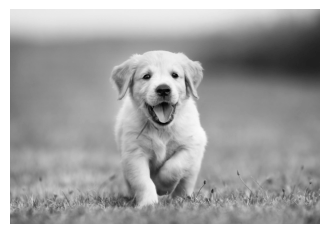

In [246]:
res = module.rgb_to_grayscale(imgc).cpu()
show_img(res, cmap='gray')

### CUDA matmul

In [204]:
cuda_src = cuda_begin + r'''
__global__ void matmul_k(float* m, float* n, float* out, int h, int w, int k) {
    int r = blockIdx.y*blockDim.y + threadIdx.y;
    int c = blockIdx.x*blockDim.x + threadIdx.x;

    if (r>=h || c>=w) return;
    float o = 0;
    for (int i = 0; i<k; ++i) o += m[r*k+i] * n[i*w+c];
    out[r*w+c] = o;
}

torch::Tensor matmul(torch::Tensor m, torch::Tensor n) {
    CHECK_INPUT(m); CHECK_INPUT(n);
    int h = m.size(0);
    int w = n.size(1);
    int k = m.size(1);
    TORCH_CHECK(k==n.size(0), "Size mismatch!");
    auto output = torch::zeros({h, w}, m.options());

    dim3 tpb(16,16);
    dim3 blocks(cdiv(w, tpb.x), cdiv(h, tpb.y));
    matmul_k<<<blocks, tpb>>>(
        m.data_ptr<float>(), n.data_ptr<float>(), output.data_ptr<float>(), h, w, k);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}
'''

In [198]:
cpp_src = "torch::Tensor matmul(torch::Tensor m, torch::Tensor n);"

In [205]:
module = load_cuda(cuda_src, cpp_src, ['matmul'])

In [200]:
m1c,m2c = m1.contiguous().cuda(), m2.contiguous().cuda()

In [201]:
torch.isclose(tr,module.matmul(m1c, m2c).cpu(), atol=1e-5).all()

tensor(True)

In [203]:
%%time
res=module.matmul(m1c, m2c).cpu()
res.shape

CPU times: user 0 ns, sys: 1.62 ms, total: 1.62 ms
Wall time: 1.18 ms


torch.Size([50000, 10])

### Pytorch

In [303]:
torch.isclose(tr,(m1c@m2c).cpu(), atol=1e-5).all()

tensor(True)

In [304]:
%timeit -n 10 _=(m1c@m2c).cpu()

474 µs ± 115 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Broadcasting

In [117]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar): c[i] = (a[i,:,None] * b).sum(dim=0)
    return c

In [127]:
torch.isclose(t1,matmul(m1, m2)).all()

tensor(True)

In [131]:
%time _=matmul(m1, m2)

CPU times: user 0 ns, sys: 1.79 ms, total: 1.79 ms
Wall time: 1.22 ms


In [139]:
m1 = x_train
tr = matmul(m1, m2)
tr.shape

torch.Size([50000, 10])

In [140]:
%time _=matmul(m1, m2)

CPU times: user 1.02 s, sys: 0 ns, total: 1.02 s
Wall time: 738 ms


In [141]:
ar,ac = m1.shape
br,bc = m2.shape
ar*bc*ac

392000000